In [1]:
from __future__ import print_function

import codecs
import re, os

from pprint import pprint
from time import time
import logging

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
def load_movies(path="../data/raw/"):
    corpus = []
    classes = []
    label = 0
    for cl in os.listdir(path):  # parcours des fichiers d'un répertoire
        for f in os.listdir(path + cl):
            txt = open(path + cl + "/" + f).read()
            corpus.append(txt)
            classes.append(label)
        label += 1  # changer de répertoire <=> changement de classe
    return corpus, classes

X, y = load_movies()
len(X)

2000

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

vectorizer = CountVectorizer(ngram_range=(3,3))
_ = vectorizer.fit_transform(X_train)
s = len(vectorizer.vocabulary_)
print(s)

762018


In [4]:
times = {"nb": [], "lr": [], "svm": []}
for features in range(10000, s, 10000):
    vectorizer = CountVectorizer(ngram_range=(2,2), max_features=features)
    X_train_2 = vectorizer.fit_transform(X_train)
    t0 = time()
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train_2, y_train)
    times["nb"].append(time() - t0)
    t0 = time()
    nb_clf = LogisticRegression(max_iter=10000)
    nb_clf.fit(X_train_2, y_train)
    times["lr"].append(time() - t0)
    t0 = time()
    nb_clf = LinearSVC(max_iter=10000)
    nb_clf.fit(X_train_2, y_train)
    times["svm"].append(time() - t0)

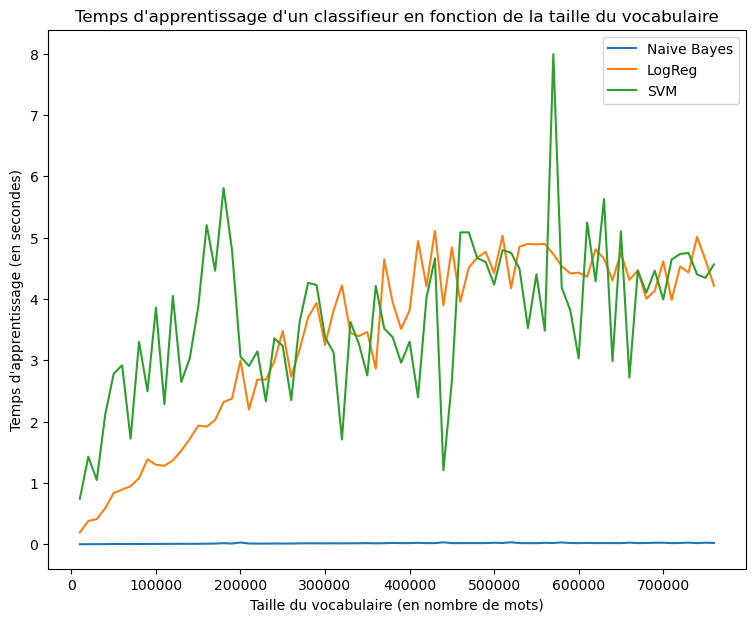

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,7))
plt.plot(range(10000, s, 10000), times["nb"], label="Naive Bayes")
plt.plot(range(10000, s, 10000), times["lr"], label="LogReg")
plt.plot(range(10000, s, 10000), times["svm"], label="SVM")
plt.legend()
plt.xlabel("Taille du vocabulaire (en nombre de mots)")
plt.ylabel("Temps d'apprentissage (en secondes)")
plt.title("Temps d'apprentissage d'un classifieur en fonction de la taille du vocabulaire")

plt.savefig("../reports/figures/complexity_analysis_vocabulary.png", dpi=100, bbox_inches="tight")
plt.show()

wtf le svm

In [8]:
import numpy as np
print("nb median", np.median(times["nb"]))
print("lr median", np.median(times["lr"]))
print("svm median", np.median(times["svm"]))

nb median 0.002021312713623047
lr median 0.3700079917907715
svm median 1.0711371898651123


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import itertools

# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline_nb = Pipeline(
    [
        ("vect", CountVectorizer()),
        (
            "tfidf",
            TfidfTransformer(),
        ),
        ("nb", MultinomialNB()),
    ]
)

pipeline_lr = Pipeline(
    [
        ("vect", CountVectorizer()),
        (
            "tfidf",
            TfidfTransformer(),
        ),
        ("lr", LogisticRegression(max_iter=10000)),
    ]
)

pipeline_svm = Pipeline(
    [
        ("vect", CountVectorizer()),
        (
            "tfidf",
            TfidfTransformer(),
        ),
        ("svm", LinearSVC(max_iter=10000)),
    ]
)


# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    "vect__min_df": (0.15, 1),
    "vect__max_df": (0.5, 1.0),
    "vect__max_features": (None, 20000, 200000),
    "vect__lowercase": (False, True),
    "vect__strip_accents": (None, "unicode"),
    "vect__stop_words": (None, stopwords.words("english")),
    "vect__ngram_range": ((1, 1),(1, 2)),  # unigrams or bigrams
    "vect__binary": (True, False),
    "tfidf__use_idf": (True, False),
    "tfidf__norm": (None, "l1", "l2"),
    "tfidf__smooth_idf": (True, False),
    "tfidf__sublinear_tf": (False, True),
}


if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    times_gs = {"nb": [], "lr": [], "svm": []}
    nb_fits = {"nb": [], "lr": [], "svm": []}
    
    for p in range(1, 10):
        param = dict(itertools.islice(parameters.items(), p))
        
        grid_search = GridSearchCV(
            pipeline_nb, param, n_jobs=-1, verbose=1, scoring="roc_auc"
        )
        ## NB
        t0 = time()
        grid_search.fit(X, y)
        times_gs["nb"].append(time() - t0)
        nb_fits["nb"].append(len(grid_search.cv_results_["params"]) * 5)
        ## RegLog
        grid_search = GridSearchCV(
            pipeline_lr, param, n_jobs=-1, verbose=1, scoring="roc_auc"
        )
        t0 = time()
        grid_search.fit(X, y)
        times_gs["lr"].append(time() - t0)
        nb_fits["lr"].append(len(grid_search.cv_results_["params"]) * 5)
        ## SVM
        grid_search = GridSearchCV(
            pipeline_svm, param, n_jobs=-1, verbose=1, scoring="roc_auc"
        )
        t0 = time()
        grid_search.fit(X, y)
        times_gs["svm"].append(time() - t0)
        nb_fits["svm"].append(len(grid_search.cv_results_["params"]) * 5)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for eac

KeyboardInterrupt: 

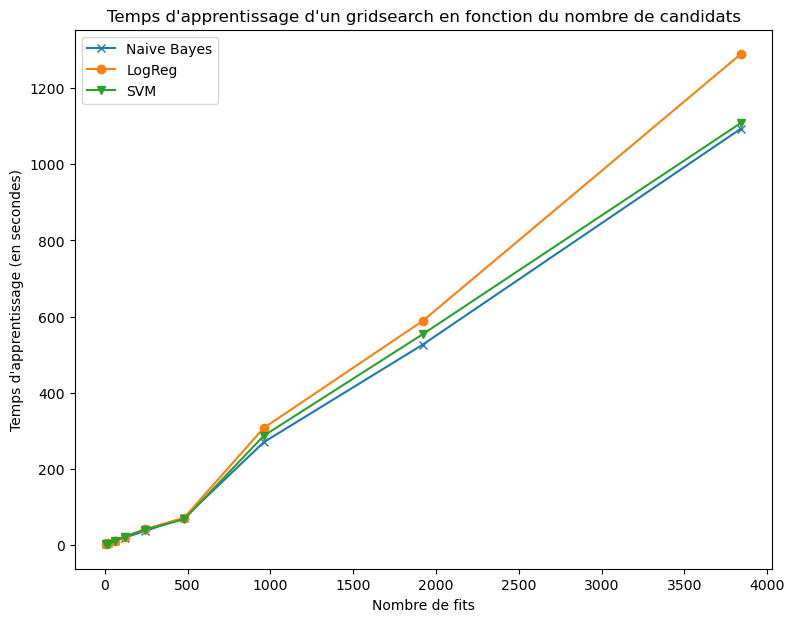

In [52]:
plt.figure(figsize=(9,7))
plt.plot(nb_fits["nb"], times_gs["nb"], "-x", label="Naive Bayes")
plt.plot(nb_fits["lr"], times_gs["lr"], "-o", label="LogReg")
plt.plot(nb_fits["svm"], times_gs["svm"], "-v", label="SVM")
plt.legend()
plt.xlabel("Nombre de fits")
plt.ylabel("Temps d'apprentissage (en secondes)")
plt.title("Temps d'apprentissage d'un gridsearch en fonction du nombre de candidats")

plt.savefig("part2_estimations_gridsearch.png", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
import json
with open('nb_fits.json', 'w') as fp:
    json.dump(nb_fits, fp)

with open('times_gs.json', 'w') as fp:
    json.dump(times_gs, fp)